In [83]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary

import tqdm
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

### **Loading Data**

In [ ]:
# Define transformations
transform = transforms.Compose([
  transforms.ToTensor(),  # Convert data to tensors
])

# Load MNIST dataset with normalization
train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

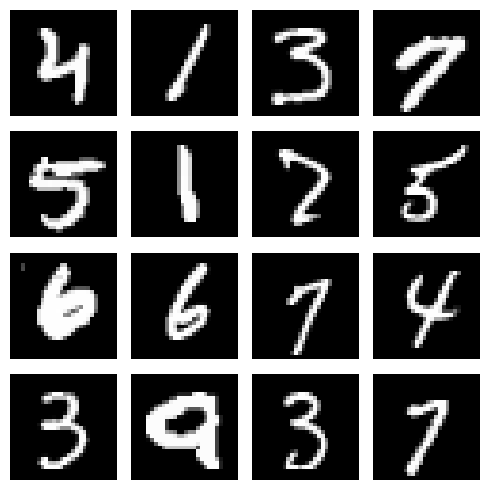

In [ ]:
# Get a batch of images from the data loader
images, _ = next(iter(train_loader))

# Convert images to NumPy arrays for Matplotlib
images = images.numpy()

# Plot some images in a grid
num_images = 16  # Adjust as needed
plt.figure(figsize=(5, 5))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def plot_reconstruction(img, recons):
    """
    Plot the original and reconstructed images during training
    """
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(7, 3))

    recons = recons.detach().cpu().numpy()
    recons = np.reshape(recons, (recons.shape[0],1,28,28))

    for j in range(5):
        axes[0][j].imshow(np.squeeze(img[j].detach().cpu().numpy()), cmap='gray')
        axes[0][j].axis('off')

    for j in range(5):
        # recons[j] = np.reshape(recons[j].detach().cpu().numpy(), (1,28,28))
        axes[1][j].imshow(np.squeeze(recons[j]), cmap='gray')
        axes[1][j].axis('off')

    plt.tight_layout(pad=0.)
    plt.show()

### **VAE Model**

In [ ]:
class VAEmodel(nn.Module):
    def __init__(self, latent_dims, hidden_dims, image_shape):

        super(VAEmodel, self).__init__()

        self.latent_dims = latent_dims #Size of the latent space layer
        self.hidden_dims = hidden_dims #List of hidden layers number of filters/channels
        self.image_shape = image_shape #Input image shape

        self.last_layer_shape = self.hidden_dims[-1]
        self.input_shape = self.image_shape[0]*self.image_shape[1]*self.image_shape[2]

        modules = []
        modules.append
        for h_dim in self.hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features = self.input_shape , out_features = h_dim),
                    nn.LeakyReLU()
                )
            )
            self.input_shape = h_dim

        self.encoder = nn.Sequential(*modules)

        # Here are our layers for our latent space distribution
        self.fc_mu = nn.Linear(self.last_layer_shape, latent_dims)
        self.fc_var = nn.Linear(self.last_layer_shape, latent_dims)

        # Decoder input layer
        self.decoder_input = nn.Linear(latent_dims, self.last_layer_shape)

        # For each Convolution Block created on the Encoder we will do a symmetric Decoder with the same Blocks, but using ConvTranspose
        self.hidden_dims.reverse()

        modules = []
        for h_dim in self.hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features = self.input_shape, out_features= h_dim),
                    nn.LeakyReLU()
                )
            )
            self.input_shape = h_dim

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.Linear(in_features = self.input_shape, out_features = self.image_shape[0]*self.image_shape[1]*self.image_shape[2] , bias=True),
            nn.Sigmoid()
        )

    def get_latent_dims(self):

        return self.latent_dims

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        """
        result = torch.flatten(input, start_dim=1)
        result = self.encoder(result)
        # result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var componentsbof the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes onto the image space.
        """
        result = self.decoder_input(z)
        result = self.decoder(result)
        result = self.final_layer(result)

        return result

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def forward(self, input):
        """
        Forward method which will encode and decode our image.
        """
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)

        return  [self.decode(z), input, mu, log_var, z]

    def loss_function(self, recons, input, mu, log_var):
        """
        Computes VAE loss function
        """
        recons_loss = nn.functional.binary_cross_entropy(recons.reshape(recons.shape[0],-1),
                                                         input.reshape(input.shape[0],-1),
                                                         reduction="none").sum(dim=-1)

        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=-1)

        loss = (recons_loss + kld_loss).mean(dim=0)

        return loss

    def sample(self, num_samples, device):
        """
        Samples from the latent space and return the corresponding
        image space map.
        """
        z = torch.randn(num_samples, self.latent_dims)
        z = z.to(device)
        samples = self.decode(z)

        return samples

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VAE = VAEmodel(latent_dims=20, hidden_dims=[128, 32], image_shape=[1,28,28])

print(VAE)

VAEmodel(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=32, out_features=20, bias=True)
  (fc_var): Linear(in_features=32, out_features=20, bias=True)
  (decoder_input): Linear(in_features=20, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (final_layer): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


### **Training VAE**

In [ ]:

VAE = VAE.to(device)
VAE.train()

epochs = 10

optimizer = torch.optim.Adam(VAE.parameters(), lr=1e-2)

for epoch in range(epochs):
    total_loss = 0
    with tqdm(train_loader, unit="batch") as t_epoch:
        t_epoch.set_description(f"Epoch {epoch+1}/{epochs}")
        for batch_idx, batch in enumerate(t_epoch):
            img = batch[0].to(device)

            optimizer.zero_grad()

            recons, input, mu, log_var, _ = VAE.forward(img)

            loss = VAE.loss_function(recons, input, mu, log_var)

            loss.backward()

            optimizer.step()

            total_loss += loss.item()
            t_epoch.set_postfix(loss = total_loss / (batch_idx + 1))

Epoch 10/10: 100%|██████████| 600/600 [00:11<00:00, 54.15batch/s, loss=127]


### **Sample Generations**

In [ ]:
VAE.eval()
num_samples = 15
samples = VAE.sample(num_samples = num_samples, device=device)
samples = samples.detach().cpu().numpy()
samples = np.reshape(samples, (num_samples,28,28))

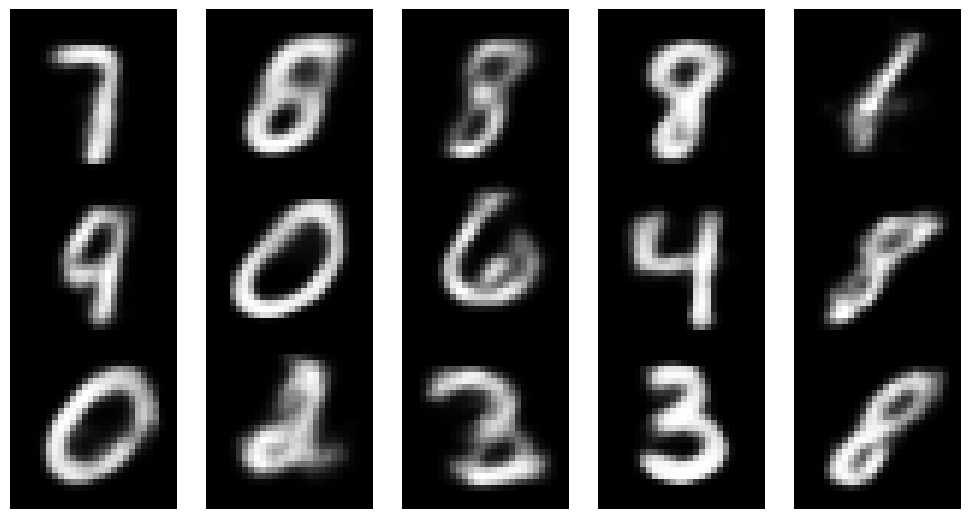

In [ ]:
# show reconstructions
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 5))
k=0
for i in range(3):
    for j in range(5):
        axes[i][j].imshow(samples[k], cmap='gray')
        axes[i][j].axis('off')
        k=k+1
plt.tight_layout(pad=0.)

### **VAE Performance on MNIST Dataset**

#### Observations:

- **Digit Generation**: The VAE effectively generates images of all digits (0-9), showcasing its capability to capture essential digit characteristics.
- **Model Architecture**: The VAE architecture, comprising encoder and decoder networks, facilitates digit generation from learned latent representations.
- **Loss Function**: Balancing reconstruction and KL divergence losses enables the model to produce diverse and realistic digit samples.
- **Training**: Training for 10 epochs on the MNIST dataset allows the VAE to learn representations and generate new digit images effectively.

#### Explanations:

- **Effective Digit Generation**: Despite slight blurriness, the VAE captures digit diversity and structure, leveraging learned latent representations.
- **Latent Space**: Encoded latent space representations enable smooth digit interpolation and manipulation, contributing to versatile digit generation.
- **Reconstruction Quality**: Minor blurriness may stem from model complexity or loss function trade-offs, suggesting potential for improvement through hyperparameter tuning and architecture refinement.

#### Conclusions:

- **Versatile Generation**: The VAE demonstrates versatility in generating recognizable digit images across all classes, highlighting its potential for various applications.
- **Continuous Improvement**: Iterative experimentation and fine-tuning of model parameters can enhance image sharpness and realism, advancing VAE performance.
- **Evaluation**: Ongoing evaluation using qualitative and quantitative metrics ensures the model's suitability for practical applications, guiding further refinement efforts.